## Trying to plot the mode intensity of the material
---

### The QCL material and structure
- The code represents the same material structure of the figure.  
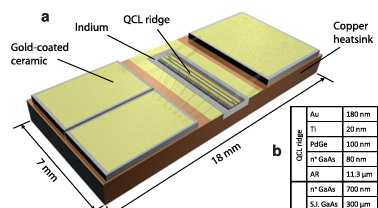
- The height is in the y axis, the length is in the x axis.  
- Grating structure is also recorded in this part of the code.  

In [ ]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from meep.materials import Au,GaAs
from QCL_materials import substrate_GaAs

###----------------------------------basic config----------------------------------###
dpml = 1  # PML thickness
resolution = 50
# thickness of different layers（1 μm）
Au_thickness = 0.2
nGaAs_thickness_1 = 0.08
Active_region_thickness = 11.3
nGaAs_thickness_2 = 0.7
substrate_GaAs_thickness = 30
# w = au_thickness + ngaas_thickness_1 + Active_region_thickness + ngaas_thickness_2 + sigaas_thickness # width of waveguide

###---------------------------------material config----------------------------------###
# material definition
Active_region = GaAs
# Au = mp.Medium(epsilon=1.0, D_conductivity=1e7)
GaAs_low_doped = mp.Medium(epsilon=12.9, 
                           D_conductivity=0)
GaAs_high_doped = mp.Medium(epsilon=5, 
                            D_conductivity=100)

###------------------------------------geometry------------------------------------###
material_H = Au_thickness + nGaAs_thickness_1 + Active_region_thickness + nGaAs_thickness_2 + substrate_GaAs_thickness
x0 = -0.5 * (Au_thickness + nGaAs_thickness_1 + Active_region_thickness + 
             nGaAs_thickness_2 + substrate_GaAs_thickness)

def add_layer(thickness:float, material:mp.Medium):
    """add layers through x axis"""
    global x0
    geometry.append(mp.Block(material=material,
                             size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(x0 + 0.5 * thickness, 0, 0),
                             ))
    x0 += thickness

geometry = []
# Substrate
add_layer(substrate_GaAs_thickness, substrate_GaAs)
add_layer(nGaAs_thickness_2,        GaAs_high_doped)

# QCL active region
add_layer(Active_region_thickness,  GaAs)

# upper layers
add_layer(nGaAs_thickness_1,        GaAs_high_doped)
add_layer(Au_thickness,             Au)

###------------------------------------grating parameters-----------------------------------------###
pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
pattern = pattern_1 + pattern_2
slot_depth = 50
slot_width = 0.1
line = 1
dash = line * 1.5
sz_length = 0
for symbol in pattern:
    sz_length += line if symbol == '|' else dash

z_start = -sz_length/2
x_grating_center = x0 + material_H - 0.5 * Au_thickness
z_pos = -sz_length/2

def add_grating(pattern:list,grating_geometry:list):
    """ add grating structure through z axis"""
    global z_pos
    for symbol in pattern:
        z_pos = z_pos + line if symbol == "|" else z_pos + dash
        grating_geometry.append(mp.Block(
                            material=mp.air,
                            size=mp.Vector3(slot_depth,mp.inf,slot_width),
                            center=mp.Vector3(x=x_grating_center,z=z_pos)))

grating_geometry = []
add_grating(pattern,grating_geometry)

geometry += grating_geometry
###---------------------------------------cell setup----------------------------------------------------###
sx = material_H + 2*dpml
sy = 0
sz = sz_length + 2*dpml + 2
cell = mp.Vector3(sx, sy, sz)

fcen = 2.85e12 # 2.85THz
df = 0.2  # pulse frequency width

src = [mp.Source(mp.ContinuousSource(fcen, fwidth=df),
        component=mp.Ey,
        center=mp.Vector3(0,0,-0.5 * sz + dpml),
        size=mp.Vector3(z=sx)
        )]

###-------------------------------------simulation setup-----------------------------------------------###
sim = mp.Simulation(
                cell_size=cell,
                geometry=geometry,
                boundary_layers=[mp.PML(dpml, direction=mp.X),
                                 mp.PML(dpml, direction=mp.Z)],
                sources=src,
                resolution=resolution)
sim.plot2D()


### Trying to reappear mode intensity with another 2 structure
---
- Plasmon waveguide  
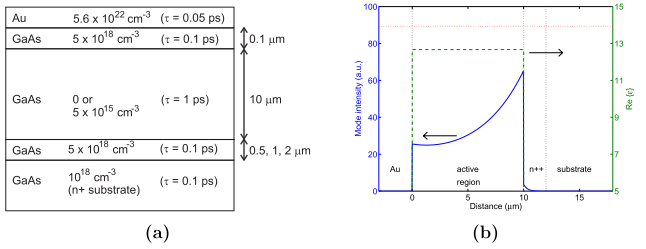
  
- Metal-metal waveguide  
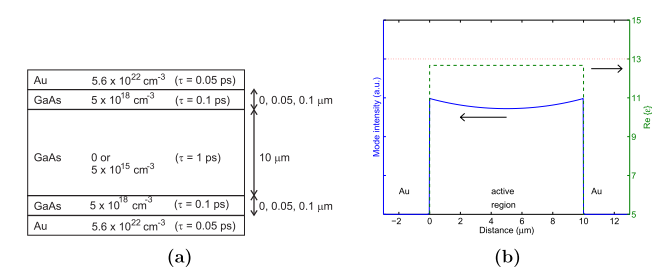

- The height is in the x axis and length is in the z axis.  

#### using the continuous source and drude model

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au,GaAs
from QCL_materials import GaAs_active,nSI_GaAs,substrate_GaAs,material_au,material_gaas_doped,material_gaas_lightly_doped,material_gaas_substrate


# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 1
nSI_GaAs_thickness = 0.1
Active_GaAs_thickness = 10
substrate_GaAs_thickness = 5

###-------------------------basic config--------------------------------------###
# Set up for source frequency 
c = 3e8
frequency = 5e12
freq_in_meep = frequency * 1e-6 / 3e8 # 5THz
wavelength = c/frequency
# Set up for detector 's observe range
observe_range = 0.1

###--------------------------geometry------------------------------------------###
# define the basic height of layers
def add_layer(thickness, material):
    global x0
    center_x = x0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(center_x, 0, 0),
                             material=material))
    x0 += thickness

# Construct layers
geometry = []

# switch to Plasmon structure
# material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness
# x0 = -0.5 * (Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness)
# add_layer(substrate_GaAs_thickness, substrate_GaAs)
# add_layer(2,                        nSI_GaAs)

# switch to Metal-metal structure
material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + nSI_GaAs_thickness + Au_thickness
x0 = -0.5 * material_height
add_layer(Au_thickness,         Au)
add_layer(nSI_GaAs_thickness,   nSI_GaAs)
# other layers
add_layer(Active_GaAs_thickness,    GaAs_active)
add_layer(nSI_GaAs_thickness,       nSI_GaAs)
add_layer(Au_thickness,             Au)

###-------------------------source---------------------------###
resolution = 50
sx = material_height
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)

sources = [mp.Source(
                    # src=mp.ContinuousSource(wavelength=wavelength),
                    src=mp.ContinuousSource(frequency=freq_in_meep),
                    amplitude=10,
                    component=mp.Ex,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(material_height,0,0)),
                    ]


###----------------------simulation setup------------------###
# basic setup (1 μm)
def plot_Ex(sim:mp.simulation):
    """sample Ex on x axis in the simulation"""
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x])
    ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2) for xi in x])
    ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2) for xi in x])
    ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2) for xi in x])


    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ey|', color=color)
    ax1.plot(x, ey_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ey_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ez|', color=color)
    ax1.plot(x, ez_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ez_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()


dpml = 0.1
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=[mp.PML(dpml, direction=mp.X),
    #                  mp.PML(dpml, direction=mp.Z)],
    geometry=geometry,
    sources=sources,
    dimensions=2)

sim.plot2D()
sim.run(until=10)
plot_Ex(sim)

# for i in range (0,10,1):
#     sim.run(until=i)
#     plot_Ex(sim)


#### using the eigenmode source and real epsilon parameters

     block, center = (-5.6,0,0)
          size (1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.8841,4.8841,4.8841)
     block, center = (-5.05,0,0)
          size (0.1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (20.7025,20.7025,20.7025)
     block, center = (0,0,0)
          size (10,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (5.05,0,0)
          size (0.1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (20.7025,20.7025,20.7025)
     block, center = (5.6,0,0)
          size (1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.8841,4.8841,4.8841)
-----------
Initializing structure...
time for choose_chunkdivision = 1.90735e-05 s
Working in 2D dimensions.

/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/meep/source.py:594: RuntimeWarning: EigenModeSource component is not ALL_COMPONENTS (the default), which makes it non-unidirectional.
  warnings.warn(
/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/matplotlib/transforms.py:2875: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


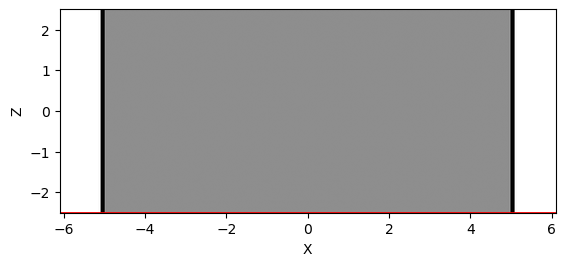

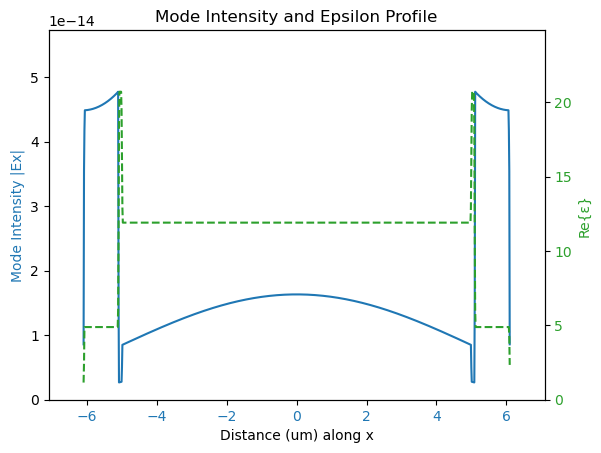

In [2]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au,GaAs
from QCL_materials import Au_XD,GaAs_Act_XD,GaAs_High_XD


# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 1
nSI_GaAs_thickness = 0.1
Active_GaAs_thickness = 10
substrate_GaAs_thickness = 5

###-------------------------basic config--------------------------------------###
# Set up for source frequency 
c = 3e8
frequency = 5e12
freq_in_meep = frequency * 1e-6 / 3e8 # 5THz
wavelength = c/frequency
# Set up for detector 's observe range
observe_range = 0.1

###--------------------------geometry------------------------------------------###
# define the basic height of layers
def add_layer(thickness, material):
    global x0
    center_x = x0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(center_x, 0, 0),
                             material=material))
    x0 += thickness

# Construct layers
geometry = []

# switch to Plasmon structure
# material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness
# x0 = -0.5 * (Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + 2 + substrate_GaAs_thickness)
# add_layer(substrate_GaAs_thickness, substrate_GaAs)
# add_layer(2,                        nSI_GaAs)

# switch to Metal-metal structure
material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + nSI_GaAs_thickness + Au_thickness
x0 = -0.5 * material_height
add_layer(Au_thickness,         Au_XD)
add_layer(nSI_GaAs_thickness,   GaAs_High_XD)
# other layers
add_layer(Active_GaAs_thickness,    GaAs_Act_XD)
add_layer(nSI_GaAs_thickness,       GaAs_High_XD)
add_layer(Au_thickness,             Au_XD)

###-------------------------source---------------------------###
resolution = 50
sx = material_height
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)


sources = [mp.EigenModeSource(
            src=mp.ContinuousSource(frequency=freq_in_meep),
            center=mp.Vector3(0,0,-sz/2),
            size=mp.Vector3(material_height,0,0),
            component = mp.Ex,
            # direction=mp.X,
)]
###----------------------simulation setup------------------###
# basic setup (1 μm)
def plot_Ex(sim:mp.simulation):
    """sample Ex on x axis in the simulation"""
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x])
    ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2) for xi in x])

    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, np.max(eps_data)*1.2)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()

dpml = 0.1
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=[mp.PML(dpml, direction=mp.X),
    #                  mp.PML(dpml, direction=mp.Z)],
    geometry=geometry,
    sources=sources,
    dimensions=2)

sim.plot2D()
sim.run(until=10)
plot_Ex(sim)

# for i in range (0,10,1):
#     sim.run(until=i)
#     plot_Ex(sim)


### Try the default materials (epsilon = 13) and plot the mode intensity from 3 directions
---

     block, center = (0,0,0)
          size (12.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
-----------
Initializing structure...
time for choose_chunkdivision = 1.78814e-05 s
Working in 2D dimensions.
Computational cell is 12.2 x 0.02 x 0 with resolution 50
     block, center = (0,0,0)
          size (12.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.00163603 s
-----------
run 0 finished at t = 10.0 (1000 timesteps)


/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jiaxin-3/anaconda3/envs/mp/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


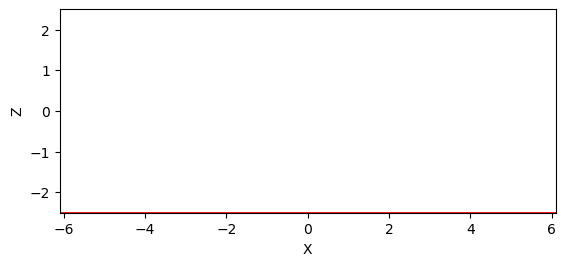

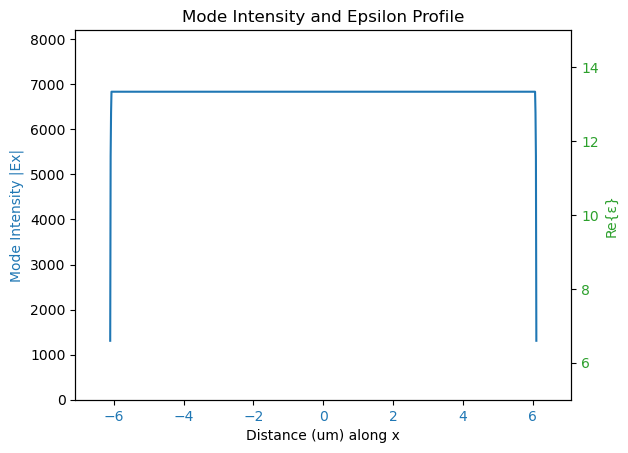

/tmp/ipykernel_9341/665190947.py:102: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(0, np.max(ey_data)*1.2)


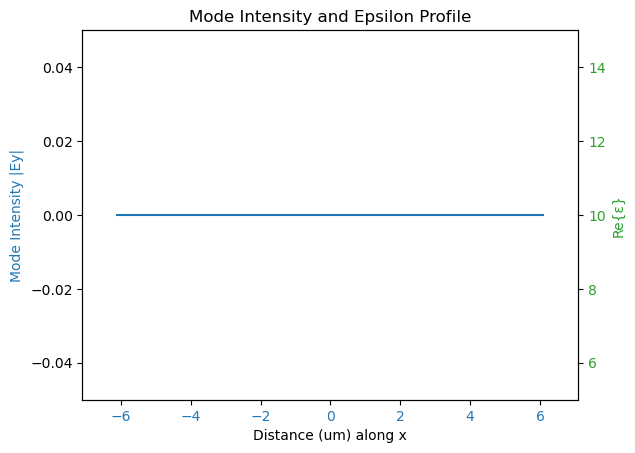

/tmp/ipykernel_9341/665190947.py:121: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim(0, np.max(ez_data)*1.2)


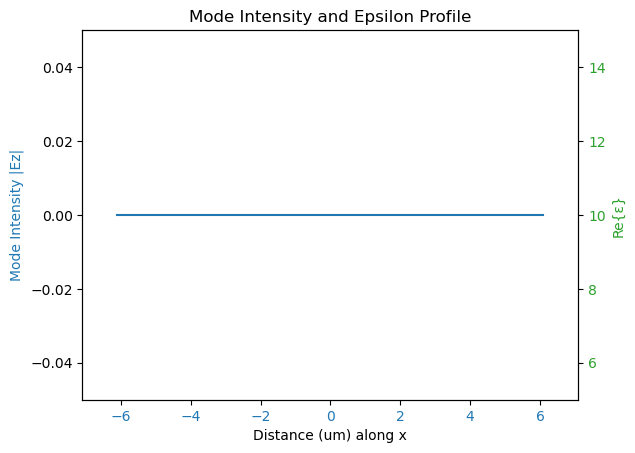

In [3]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import Au,GaAs
from QCL_materials import GaAs_active,nSI_GaAs,substrate_GaAs,material_au,material_gaas_doped,material_gaas_lightly_doped,material_gaas_substrate


# Perfectly Matched Layer if THz , set PML to 1
pml_layers = [mp.PML(1)]
# thickness of different layers（1 μm）
Au_thickness = 1
nSI_GaAs_thickness = 0.1
Active_GaAs_thickness = 10
substrate_GaAs_thickness = 5

###-------------------------basic config--------------------------------------###
# Set up for source frequency 
c = 3e8
frequency = 5e12
freq_in_meep = frequency * 1e-6 / 3e8 # 5THz
wavelength = c/frequency
# Set up for detector 's observe range
observe_range = 0.1

###--------------------------geometry------------------------------------------###
# define the basic height of layers
def add_layer(thickness, material):
    global x0
    center_x = x0 + 0.5 * thickness
    geometry.append(mp.Block(size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(center_x, 0, 0),
                             material=material))
    x0 += thickness

# Construct layers
geometry = []

# switch to Plasmon structure


# switch to Metal-metal structure
material_height = Au_thickness + nSI_GaAs_thickness + Active_GaAs_thickness + nSI_GaAs_thickness + Au_thickness
x0 = -0.5 * material_height
add_layer(material_height,        mp.air)

###-------------------------source---------------------------###
resolution = 50
sx = material_height
sy = 0
sz = 5
cell = mp.Vector3(sx, sy, sz)

sources = [mp.Source(
                    # src=mp.ContinuousSource(wavelength=wavelength),
                    src=mp.ContinuousSource(frequency=freq_in_meep),
                    amplitude=10,
                    component=mp.Ex,
                    center=mp.Vector3(0,0,-sz/2),
                    size = mp.Vector3(material_height,0,0)),
                    ]


###----------------------simulation setup------------------###
# basic setup (1 μm)
def plot_Ex(sim:mp.simulation):
    """sample Ex on x axis in the simulation"""
    x = np.linspace(-sx/2, sx/2, 1000)
    eps_data = np.array([sim.get_epsilon_point(mp.Vector3(xi,0,0)) for xi in x])
    ex_data = np.array([abs(sim.get_field_point(mp.Ex, mp.Vector3(xi))**2) for xi in x])
    ey_data = np.array([abs(sim.get_field_point(mp.Ey, mp.Vector3(xi))**2) for xi in x])
    ez_data = np.array([abs(sim.get_field_point(mp.Ez, mp.Vector3(xi))**2) for xi in x])


    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ex|', color=color)
    ax1.plot(x, ex_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ex_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ey|', color=color)
    ax1.plot(x, ey_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ey_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Distance (um) along x')
    ax1.set_ylabel('Mode Intensity |Ez|', color=color)
    ax1.plot(x, ez_data, color=color)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.set_xlim(-sx/2-1,sx/2+1)
    ax1.set_ylim(0, np.max(ez_data)*1.2)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Re{ε}', color=color)
    ax2.plot(x, eps_data, color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(5, 15)

    plt.title('Mode Intensity and Epsilon Profile')
    plt.show()


dpml = 0.1
sim = mp.Simulation(
    cell_size=cell,
    resolution=resolution,
    # boundary_layers=[mp.PML(dpml, direction=mp.X),
    #                  mp.PML(dpml, direction=mp.Z)],
    geometry=geometry,
    sources=sources,
    dimensions=2)

sim.plot2D()
sim.run(until=10)
plot_Ex(sim)

# for i in range (0,10,1):
#     sim.run(until=i)
#     plot_Ex(sim)


### Try to check the matrix of material by meep class method
---

In [ ]:
import meep as mp

Au = mp.Medium(
    epsilon=1.0,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=0.44, gamma=0.033, sigma=1.0)])


# N = 5e18
n_GaAs = mp.Medium(
    epsilon=10.9,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=0.44, gamma=0.033, sigma=1.0)])

# N = 5e15 低参杂
light_GaAs = mp.Medium(
    epsilon=12.25,
    E_susceptibilities=[
        mp.DrudeSusceptibility(frequency=0.062, gamma=0.0033, sigma=1.0)])

# print(Au.epsilon(1/1.55))
print(n_GaAs.epsilon(1/103.4))

### Try with the official material definition
---
Conductivity and Complex ε#
Often, you only care about the absorption loss in a narrow bandwidth, where you just want to set the imaginary part of ε
 (or μ
) to some known experimental value, in the same way that you often just care about setting a dispersionless real ε
 that is the correct value in your bandwidth of interest.

One might hope that Meep would allow you to specify a constant, frequency-independent, imaginary part of ε
, but this is inherently unstable: ωImε<0
 corresponds to gain (exponential growth), but every time-domain simulation will include both positive and negative frequencies ω so there is no way to choose a nonzero frequency-independent Imε
 that does not yield gain at some ω. Instead, a simple approach in Meep is for you to set the conductivity σD
 (or σB
 for an imaginary part of μ
), chosen so that Imε=ε∞σD/ω
 is the correct value at your frequency ω
 of interest. Note that, in Meep, you specify f=ω/2π
 instead of ω
 for the frequency, however, so you need to include the factor of 2π
 when computing the corresponding imaginary part of ε
. Conductivities are absorptive at all frequencies (and are more computationally efficient than Lorentzian models).

For example, suppose you want to simulate a medium with ε=3.4+0.101i
 at a frequency 0.42 (in your Meep units), and you only care about the material in a narrow bandwidth around this frequency (i.e. you don't need to simulate the full experimental frequency-dependent permittivity). Then, in Meep, you could use meep.Medium(epsilon=3.4, D_conductivity=2*math.pi*0.42*0.101/3.4) in Python or (make medium (epsilon 3.4) (D-conductivity (* 2 pi 0.42 0.101 (/ 3.4)))) in Scheme; i.e. ε∞=Re[ε]=3.4
 and σD=ωIm[ε]/ε∞=(2π0.42)0.101/3.4
.

You can also use the σD
 feature to model the attenuation coefficient α
 (units of e.g. dB/cm) obtained from experimental measurements (i.e., ellipsometry). This involves first converting α
 into a complex refractive index (which is then converted into a complex permittivity) with imaginary part given by λ0α/(4π)
 where λ0
 is the vacuum wavelength.

Note: the "conductivity" in Meep is slightly different from the conductivity you might find in a textbook, because for computational convenience it appears as σDD
 in our Maxwell equations rather than the more-conventional σE
; this just means that our definition is different from the usual electric conductivity by a factor of ε
. Also, just as Meep uses the dimensionless relative permittivity for ε
, it uses nondimensionalized units of 1/a
 (where a
 is your unit of distance) for the conductivities σD,B
. If you have the electric conductivity σ
 in SI units of S/m (S is siemens) and want to convert to σD
 in Meep units, you can simply use the formula: σD=(a/c)σ/(εrε0)
 where a
 is your unit of distance in meters, c
 is the vacuum speed of light in m/s, ε0
 is the SI vacuum permittivity, and εr
 is the real relative permittivity. The quantity a/c
 in this equation is the conversion factor for frequency in SI units (s−1
 or Hz) to frequency in Meep units (c/a
).

通常，您只关心窄带宽中的吸收损耗，此时您只想将 ε
 （或 μ
 ） 的虚部设置为某个已知的实验值，就像您通常只关心设置一个无色散实数一样，该实 ε
 数是您感兴趣的带宽中的正确值。
 人们可能希望 Meep 允许您指定一个常数、与频率无关的虚部 ε
 ，但这本质上是不稳定的： ωImε<0
 对应于增益（指数增长），但每个时域仿真都将包括正频率和负频率 ω，因此无法选择在某个 ω 处不会产生增益的非零频率无关 Imε
 。 相反，Meep 中的一种简单方法是设置电导率 σD
 （或 σB
 针对 的 μ
 虚部 ），以便 Imε=ε∞σD/ω
 根据您感兴趣的频率 ω
 选择正确的值。请注意，在 Meep 中，您指定 f=ω/2π
 的频率是 instead of ω
 ，因此在计算 的相应虚部 时 ε
 需要包括 的 2π
 因子 。电导率在所有频率上都是可吸收的（并且比洛伦兹模型计算效率更高）。
 例如，假设您要模拟频率为 0.42 的介质 ε=3.4+0.101i
 （以 Meep 单位为单位），并且您只关心该频率附近狭窄带宽中的材料（即您不需要模拟与频率相关的完全实验介电常数）。然后，在 Meep 中，您可以在 Python 或 (make medium (epsilon 3.4) (D-conductivity (* 2 pi 0.42 0.101 (/ 3.4)))) Scheme 中使用 meep.Medium(epsilon=3.4, D_conductivity=2*math.pi*0.42*0.101/3.4) ;即 ε∞=Re[ε]=3.4
 和 σD=ωIm[ε]/ε∞=(2π0.42)0.101/3.4
 .

 您还可以使用该 σD
 特征对从实验测量（即椭偏仪）获得的衰减系数 α
 （例如 dB/cm 的单位）进行建模。这涉及首先转换为 α
 复折射率 （然后转换为复介电常数），虚部由 λ0α/(4π)
 真空波长 给出。 λ0
 注意 ：Meep 中的“电导率”与您在教科书中找到的电导率略有不同，因为为了计算方便，它看起来就像 σDD
 我们的麦克斯韦方程组一样，而不是更传统的 σE
 ;这只是意味着我们的定义与通常的电导率相差一个因子 ε
 。此外，正如 Meep 对 使用无量纲相对介电常数一样 ε
 ，它使用无量纲单位 1/ a（其中 a是你的距离单位）来表示电 σD,B导率 。如果你的电导率 σ以 S/m 的 SI 单位表示（S 是西门子），并且想转换为 σD
 Meep 单位，你可以简单地使用以下公式： σD=(a/c)σ/(εrε0)
 其中 a是你的距离单位（ 以米为单位）， c是光的真空速度，单位为 m/s， ε0是 SI 真空介电常数， εr是实际的相对介电常数。该方程中的量 a/c是以 SI 单位 （s −1或 Hz） 为单位的频率与以 Meep 单位 （ ） 为单位的频率的转换因子 c/a。